In [1]:
%matplotlib inline
from stl10_input import *
import tensorflow as tf
from keras import backend as K
from keras import initializations
from keras.models import Model, Sequential
from keras.layers import Activation, Flatten, Dense, Input, Dropout, LeakyReLU, BatchNormalization, Reshape, UpSampling2D, Convolution2D, GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop
import threading
import bcolz
import itertools
from tqdm import tqdm
from bcolz_array_iterator import BcolzArrayIterator
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from glob import glob
from importlib import reload
from keras.preprocessing import image
from concurrent.futures import ThreadPoolExecutor

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)


Using TensorFlow backend.


In [2]:
data_path = '/home/derek/jupyter/nbs/STL10/data/stl10_binary/'
training_data_path = f'{data_path}train_X.bin'
training_label_path = f'{data_path}train_y.bin'
unlabeled_data_path = f'{data_path}unlabeled_X.bin'
test_data_path = f'{data_path}test_X.bin'
test_label_path = f'{data_path}test_y.bin'

In [3]:
batch_size=32
seed = 42
np.set_printoptions(precision=4, linewidth=100)

In [60]:
import vgg16; reload(vgg16)
from vgg16 import VGG16

In [61]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

## prepare data

In [5]:
# import training data
images = read_all_images(training_data_path)
labels = read_labels(training_label_path)

class_indices = {}
class_indices_list = []
with open("./data/stl10_binary/class_names.txt") as f:
    label_number = 1
    for line in f:
        class_indices[label_number] = line.strip()
        class_indices_list.append(line.strip())
        label_number += 1
print(images.shape, labels.shape, np.unique(labels), class_indices)

(5000, 3, 96, 96) (5000,) [ 1  2  3  4  5  6  7  8  9 10] {1: 'airplane', 2: 'bird', 3: 'car', 4: 'cat', 5: 'deer', 6: 'dog', 7: 'horse', 8: 'monkey', 9: 'ship', 10: 'truck'}


In [32]:
# import test data
test_images = read_all_images(test_data_path)
test_labels = read_labels(test_label_path)

In [ ]:
# import unlabeled data
unlabeled_images = read_all_images(unlabeled_data_path)

In [8]:
len(unlabeled_images)

100000

In [7]:
def _resize(img):
    shortest = min(img.width,img.height)
    resized = np.round(np.multiply(new_s/shortest, img.size)).astype(int)
    return img.resize(resized, Image.BILINEAR)

def resize_np(np_arr):
    s = np_arr.shape
    if len(s)!=3 or s[2]!=3: return
    img = Image.fromarray(np_arr,'RGB')
    return _resize(img)

In [8]:
new_s = 224 # height and width to resize to
n = len(images); n

5000

In [9]:
tl = threading.local()
tl.place = np.zeros((new_s,new_s,3), 'uint8')

## create bcolz array and save resized images

In [10]:
path = '/home/derek/jupyter/nbs/data/stl10/'
bc_path = f'{path}trn_resized_{new_s}_r.bc'
bc_unlabeled_path = f'{path}unlabeled_trn_resized_{new_s}_r.bc'
bc_test_path = f'{path}test_resized_{new_s}_r.bc'

In [11]:
arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), chunklen=16, mode='w', rootdir=bc_path)
test_arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), chunklen=16, mode='w', rootdir=bc_test_path)
unlabeled_arr = bcolz.carray(np.empty((0, new_s, new_s, 3), 'float32'), chunklen=16, mode='w', rootdir=bc_unlabeled_path)

In [12]:
def get_slice(p, n): return slice((p-n+1)//2, p-(p-n)//2)

def app_img(arr, r):
    tl.place[:] = (np.array(r)[get_slice(r.size[1],new_s), get_slice(r.size[0],new_s)] 
        if r else 0.)
    arr.append(tl.place)

In [23]:
# resize training & test data
def resize_and_save_to_bc(bc_array, images):
    images_transposed = np.transpose(images, (0,3,2,1))
    for i in range(len(images)): 
        app_img(bc_array, resize_np(images_transposed[i]))
    bc_array.flush()
resize_and_save_to_bc(images)
resize_and_save_to_bc(test_arr, test_images)

In [163]:
# resize unlabeled data
def parrelel_resize_unlabeled_images(step, n):
    for i in tqdm(range(0, n, step)):
        with ThreadPoolExecutor(max_workers=8) as execr:
            res = execr.map(resize_np, np.transpose(unlabeled_images[i:min(i+step, n)], (0,3,2,1)))
            for r in res: 
                app_img(unlabeled_arr, r)
        unlabeled_arr.flush()
parrelel_resize_unlabeled_images(1000,len(unlabeled_images))


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


In [27]:
arr = bcolz.open(bc_path)
test_arr = bcolz.open(bc_test_path)
# unlabeled_arr = bcolz.open(bc_unlabeled_path)

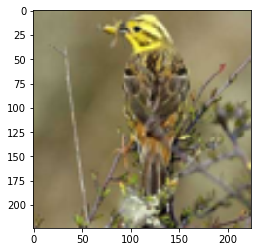

In [28]:
# let's take a look at resized images to make sure they are pristine
plt.imshow(arr[0].astype('uint8'))

In [29]:
enlarged_images = arr

In [30]:
def get_batches(images, labels, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size):
    return gen.flow(images, labels, shuffle=shuffle, batch_size=batch_size)

In [33]:
from sklearn.model_selection import train_test_split

train_set, val_set = train_test_split(list(zip(enlarged_images,labels)), test_size=0.2, random_state=seed)

train_imgs = np.array([x for x, y in train_set]) # plz use slice
print("train_imgs:",train_imgs.shape)
train_labels = np.array([y for x, y in train_set])
print("train_labels:",train_labels.shape)

val_imgs = np.array([x for x, y in val_set])
print("train_imgs:",val_imgs.shape)
val_labels = np.array([y for x, y in val_set])
print("train_labels:",val_labels.shape)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels = encoder.fit_transform(train_labels.reshape(-1,1))
train_labels = train_labels.toarray()

val_labels = encoder.fit_transform(val_labels.reshape(-1,1))
val_labels = val_labels.toarray()

test_labels = encoder.fit_transform(test_labels.reshape(-1,1))
test_labels = test_labels.toarray()

batches = get_batches(train_imgs, train_labels, batch_size=batch_size)
val_batches = get_batches(val_imgs, val_labels, batch_size=batch_size)

train_imgs: (4000, 224, 224, 3)
train_labels: (4000,)
train_imgs: (1000, 224, 224, 3)
train_labels: (1000,)


In [32]:
vgg = VGG16()

## finetune

In [33]:
def finetune(model, num_class):
    x = model.layers[-2].output
    x = Dense(num_class, activation='softmax')(x)
    new_model = Model(input=model.input, output=x)
    for layer in new_model.layers[:-1]: 
        layer.trainable=False
    return new_model
vgg = finetune(vgg, 10)

In [34]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
vgg.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_crossentropy', 'accuracy'])

In [48]:
vgg.fit_generator(batches, 4000, nb_epoch=10, validation_data=val_batches, nb_val_samples=1000)

Epoch 1/10
4000/4000 [==============================] - 60s - loss: 1.4387 - categorical_crossentropy: 1.4387 - acc: 0.8860 - val_loss: 1.5771 - val_categorical_crossentropy: 1.5771 - val_acc: 0.8820
Epoch 2/10
4000/4000 [==============================] - 52s - loss: 1.3657 - categorical_crossentropy: 1.3657 - acc: 0.8945 - val_loss: 1.6020 - val_categorical_crossentropy: 1.6020 - val_acc: 0.8800
Epoch 3/10
4000/4000 [==============================] - 51s - loss: 1.3396 - categorical_crossentropy: 1.3396 - acc: 0.8937 - val_loss: 1.4531 - val_categorical_crossentropy: 1.4531 - val_acc: 0.8810
Epoch 4/10
4000/4000 [==============================] - 48s - loss: 1.2869 - categorical_crossentropy: 1.2869 - acc: 0.8988 - val_loss: 1.6774 - val_categorical_crossentropy: 1.6774 - val_acc: 0.8750
Epoch 5/10
4000/4000 [==============================] - 48s - loss: 1.3492 - categorical_crossentropy: 1.3492 - acc: 0.8948 - val_loss: 1.3586 - val_categorical_crossentropy: 1.3586 - val_acc: 0.9010


Shape: (32, 10)
First 5 classes: ['airplane', 'bird', 'car', 'cat', 'deer']
First 5 probabilities: [ 0.  0.  0.  0.  0.]

Predictions prob/class: 
  1.0000/dog
  1.0000/deer
  1.0000/cat
  1.0000/airplane


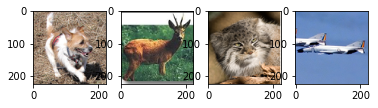

In [63]:
# get an intuition by comparing images with predictions
try_batches = get_batches(val_imgs, val_labels, batch_size=batch_size,shuffle=False)
sample_imgs, _ = next(try_batches)
preds = vgg.predict(sample_imgs)
idxs = np.argmax(preds, axis=1)

print('Shape: {}'.format(preds.shape))
print('First 5 classes: {}'.format(class_indices_list[:5]))
print('First 5 probabilities: {}\n'.format(preds[0, :5]))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i].astype('uint8'))
print('Predictions prob/class: ')

for i in range(4):
    idx = idxs[i]
    print ('  {:.4f}/{}'.format(preds[i, idx], class_indices_list[idx]))

## evaluate the performance on the test set

In [36]:
# Compare with the training and validation performance the model is slightly overfit. 
# But overall the test set performance indicated the effectiveness of our model in learning 
# from features in the training set
vgg.evaluate(test_arr, test_labels)

8000/8000 [==============================] - 88s    


[1.6986978489370086, 1.6986978489370086, 0.87162499999999998]

## save the model weights

In [30]:
DATA_HOME_DIR='.'
results_path=DATA_HOME_DIR + '/results/'
latest_weights_filename = 'ft%d.h5' % 20

In [65]:
vgg.save_weights(results_path+latest_weights_filename)

## validate predictions

In [35]:
vgg.load_weights(results_path+latest_weights_filename)

In [37]:
def test(test_imgs, test_labels, batch_size=8, shuffle=False):
    test_batches = get_batches(test_imgs, test_labels, batch_size=batch_size, shuffle=shuffle)
    return test_batches, vgg.predict_generator(test_batches, len(test_imgs))

In [38]:
# change name to validation set and then further evaluate performance on the test set; dupe var val_batches
_, preds = test(val_imgs, val_labels, batch_size=32)

In [39]:
our_labels = np.argmax(preds, axis=1)
our_preds = np.array([pred[idx] for pred, idx in zip(preds, our_labels)])
expected_labels = np.argmax(val_labels, axis=1)

3 3


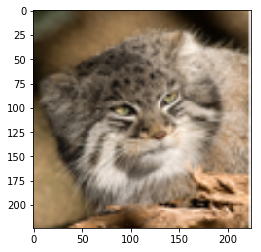

In [72]:
# take a look at a random example
print(our_labels[2], expected_labels[2])
plt.imshow(val_imgs[2].astype('uint8'))

In [73]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
    
def plots_idx(idx, titles=None):
    plots([each.astype('uint8') for each in val_imgs[idx]], titles=titles)
    
# number of images to view
n_view = 4
print(', '.join([str(each) for each in enumerate(class_indices_list)]))

(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')


Found 879 correct labels


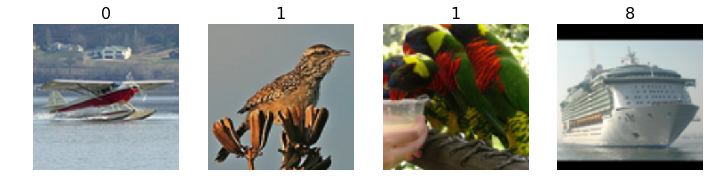

In [74]:
#1. A few correct labels at random
correct_preds = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels" % len(correct_preds))
idx = np.random.permutation(correct_preds)[:n_view]
plots_idx(idx, our_labels[idx])

Found 162 incorrect labels


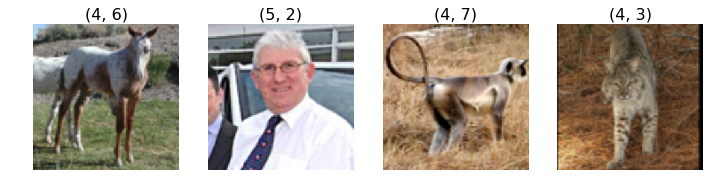

In [42]:
#2. A few incorrect labels at random
incorrect_preds = np.where(our_labels!=expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect_preds))
idx = np.random.permutation(incorrect_preds)[:n_view]
plots_idx(idx, [str(each) for each in zip(our_labels[idx], expected_labels[idx])])

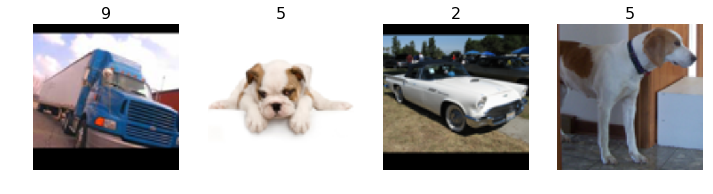

In [43]:
#3 The images we are most confident of the predictions, and actually have correct labels
most_correct_preds = np.argsort(our_preds[correct_preds])[::-1][:n_view]
plots_idx(correct_preds[most_correct_preds], our_labels[correct_preds[most_correct_preds]])

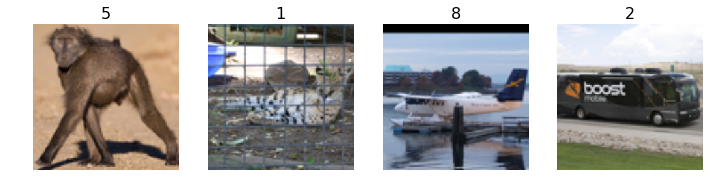

In [44]:
#4 The images we are most confident of the predictions, but end up with incorrect labels
# Most of the misclassifications are actually quite reasonable. e.g. the nn has figured 
# out the connection btw water and ships and therefore determined the seaplane was a ship
# and it's not entirely wrong.
most_incorrect_preds = np.argsort(our_preds[incorrect_preds])[::-1][:n_view]
plots_idx(incorrect_preds[most_incorrect_preds], our_labels[incorrect_preds[most_incorrect_preds]])

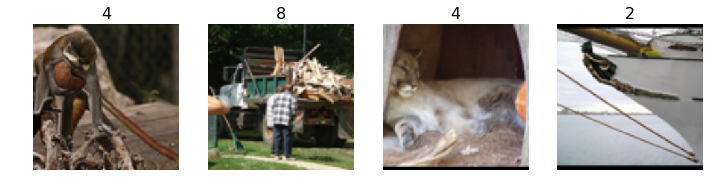

In [45]:
#5 The images we are least confident of the predictions, and indeed with the wrong labels
# as we can see most of these are even hard for human to tell 
most_incorrect_preds = np.argsort(our_preds[incorrect_preds])[:n_view]
plots_idx(incorrect_preds[most_incorrect_preds], our_labels[incorrect_preds[most_incorrect_preds]])

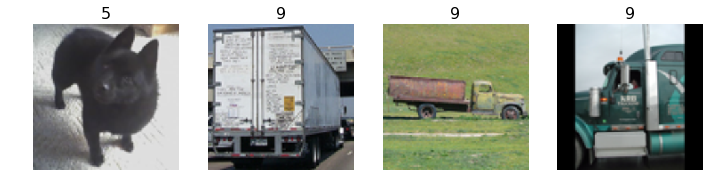

In [46]:
#6 The images we least confident of the predictions, but turn out to be correct
most_correct_preds = np.argsort(our_preds[correct_preds])[:n_view]
plots_idx(correct_preds[most_correct_preds], our_labels[correct_preds[most_correct_preds]])

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

In [41]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[ 90   0   0   0   0   0   0   0   3   0]
 [  0  82   0   1   1   3   0   2   0   0]
 [  0   0 113   0   0   1   0   0   0   0]
 [  1   2   0  72   8   7   0   1   0   0]
 [  1   1   0   3  85   2   3   0   0   0]
 [  1   0   0   6   5  95   4   2   1   0]
 [  1   1   0   3   4   6  83   1   0   1]
 [  0   2   0   3   3   5   2  86   0   0]
 [  4   0   0   0   0   0   0   0 103   0]
 [  3   0  20   0   0   0   0   0   3  70]]


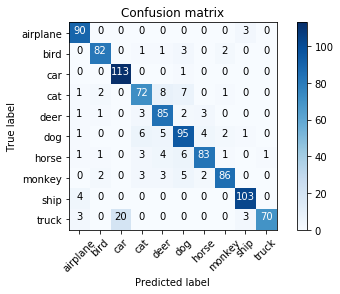

In [42]:
plot_confusion_matrix(cm, class_indices_list)

Looking at the confusion matrix we can see that our model has performed generally well. The biggest confusion it has is between car and truck which is relatively benign since the two categories do share many similarities in nature. Potential next steps to improve the performance of our model includes,
1. early stopping to improve the generalization of our model
2. data augmentation and/or tuning the train validation split ratio to introduce more data in our training
3. stratified sampling among training categories to finetune the precision/recall ratios based on characteristics of a particular task 
4. utilizing the large number of unlabeled data to help our model better learn about the underlying distribution of the dataset 

## Experiment with Unlabeled data

Here below is my failed attempt in trying to make use of the unlabeled data to help the classification task by training a WGAN with them 

### normalize image data for GAN training

In [22]:
bc_unlabeled_normalized_path = f'{path}unlabeled_trn_resized_{new_s}_normalized_r.bc'

In [23]:
# unlabeled_normalized_arr = bcolz.carray(np.empty((0, 224, 224, 3), 'float32'), chunklen=16, mode='w', rootdir=bc_unlabeled_normalized_path)

In [24]:
def inverse_normalization(X):

    return ((X * 0.5 + 0.5) * 255.).astype(np.uint8)

In [25]:
def normalization(X, image_dim_ordering):

    X = X / 255.
    if image_dim_ordering == "tf":
        X = (X - 0.5) / 0.5
    else:
        X = (X - 0.5) / 0.5

    return X

In [173]:
# change it to a closure pattern to reuse
def parrelel_normalize_unlabeled_images(step, n):
    for i in tqdm(range(0, n, step)):
        with ThreadPoolExecutor(max_workers=8) as execr:
            res = execr.map(lambda x: normalization(np.array(resize_np(x)) , 'tf') , np.transpose(unlabeled_images[i:min(i+step, n)], (0,3,2,1)))
            for r in res: 
                tl.place[:] = r
                unlabeled_normalized_arr.append(r)
        unlabeled_normalized_arr.flush()
parrelel_normalize_unlabeled_images(1000,len(unlabeled_images))


100%|██████████| 100/100 [03:21<00:00,  2.48s/it]


In [26]:
unlabeled_normalized_arr = bcolz.open(bc_unlabeled_normalized_path)

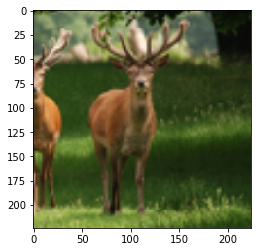

In [27]:
plt.imshow(inverse_normalization(unlabeled_normalized_arr[10]).astype('uint8'))

In [17]:
from keras.utils import visualize_util
def visualize_model(model):
    model.summary()
    visualize_util.plot(model,
                        to_file='./figures/%s.png' % model.name,
                        show_shapes=True,
                        show_layer_names=True)

In [18]:
def discriminator(img_dim, bn_mode, model_name="discriminator", visualize=False):
    """DCGAN discriminator
    """

    if K.image_dim_ordering() == "th":
        bn_axis = 1
        min_s = min(img_dim[1:])
    else:
        bn_axis = -1
        min_s = min(img_dim[:-1])

    disc_input = Input(shape=img_dim, name="discriminator_input")

    # Get the list of number of conv filters
    # (first layer starts with 64), filters are subsequently doubled
    nb_conv = int(np.floor(np.log(min_s // 4) / np.log(2)))
    list_f = [64 * min(8, (2 ** i)) for i in range(nb_conv)]

    # First conv with 2x2 strides
    x = Convolution2D(list_f[0], 3, 3, subsample=(2, 2), name="disc_conv2d_1",
                      border_mode="same", bias=False, init=conv2D_init)(disc_input)
    x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
    x = LeakyReLU(0.2)(x)

    # Conv blocks: Conv2D(2x2 strides)->BN->LReLU
    for i, f in enumerate(list_f[1:]):
        name = "disc_conv2d_%s" % (i + 2)
        x = Convolution2D(f, 3, 3, subsample=(2, 2), name=name, border_mode="same", bias=False, init=conv2D_init)(x)
        x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
        x = LeakyReLU(0.2)(x)

    # Last convolution
    x = Convolution2D(1, 3, 3, name="last_conv", border_mode="same", bias=False, init=conv2D_init)(x)
    # Average pooling
    x = GlobalAveragePooling2D()(x)

    discriminator_model = Model(input=[disc_input], output=[x], name=model_name)
    if visualize:
        visualize_model(discriminator_model)

    return discriminator_model

In [19]:
def generator_upsampling(noise_dim, img_dim, bn_mode, model_name="generator_upsampling", visualize=False):
    """DCGAN generator based on Upsampling and Conv2D
    """

    s = img_dim[1]
    f = 512
    start_dim = int(s / 16)
    nb_upconv = 4

    if K.image_dim_ordering() == "th":
        bn_axis = 1
        reshape_shape = (f, start_dim, start_dim)
        output_channels = img_dim[0]
    else:
        reshape_shape = (start_dim, start_dim, f)
        bn_axis = -1
        output_channels = img_dim[-1]

    gen_input = Input(shape=noise_dim, name="generator_input")

    # Noise input and reshaping
    x = Dense(f * start_dim * start_dim, input_dim=noise_dim)(gen_input)
    x = Reshape(reshape_shape)(x)
    x = BatchNormalization(mode=bn_mode, axis=bn_axis)(x)
    x = Activation("relu")(x)

    # Upscaling blocks: Upsampling2D->Conv2D->ReLU->BN->Conv2D->ReLU
    for i in range(nb_upconv):
        x = UpSampling2D(size=(2, 2))(x)
        nb_filters = int(f / (2 ** (i + 1)))
        x = Convolution2D(nb_filters, 3, 3, border_mode="same", init=conv2D_init)(x)
        x = BatchNormalization(mode=bn_mode, axis=1)(x)
        x = Activation("relu")(x)
        x = Convolution2D(nb_filters, 3, 3, border_mode="same", init=conv2D_init)(x)
        x = Activation("relu")(x)

    # Last Conv to get the output image
    x = Convolution2D(output_channels, 3, 3, name="gen_conv2d_final",
                      border_mode="same", activation='tanh', init=conv2D_init)(x)

    generator_model = Model(input=[gen_input], output=[x], name=model_name)
    if visualize:
        visualize_model(generator_model)

    return generator_model

def conv2D_init(shape, name=None, dim_ordering='tf'):
    return initializations.normal(shape, scale=0.02, name=name)

In [21]:
def gen_batch(X, batch_size):
    while True:
        idx = np.random.choice(X.shape[0], batch_size, replace=False)
        yield X[idx]


def sample_noise(noise_scale, batch_size, noise_dim):
    return np.random.normal(scale=noise_scale, size=(batch_size, noise_dim[0]))


def get_disc_gen_batch(generator_model, batch_size, noise_dim, noise_scale=0.5):
    # Pass noise to the generator
    noise_input = sample_noise(noise_scale, batch_size, noise_dim)
    # Produce an output
    X_disc_gen = generator_model.predict(noise_input, batch_size=batch_size)

    return X_disc_gen


def save_model_weights(generator_model, discriminator_model, DCGAN_model, e):
    model_path = "/home/derek/jupyter/nbs/data/stl10"

    gen_weights_path = os.path.join(model_path, '%s_epoch%s.h5' % (generator_model.name, e))
    generator_model.save_weights(gen_weights_path, overwrite=True)

    disc_weights_path = os.path.join(model_path, '%s_epoch%s.h5' % (discriminator_model.name, e))
    discriminator_model.save_weights(disc_weights_path, overwrite=True)

    DCGAN_weights_path = os.path.join(model_path, '%s_epoch%s.h5' % (DCGAN_model.name, e))
    DCGAN_model.save_weights(DCGAN_weights_path, overwrite=True)

In [22]:
def DCGAN(generator, discriminator, noise_dim, img_dim):
    """DCGAN generator + discriminator model
    """

    noise_input = Input(shape=noise_dim, name="noise_input")
    generated_image = generator(noise_input)
    DCGAN_output = discriminator(generated_image)

    DCGAN = Model(input=[noise_input],
                  output=[DCGAN_output],
                  name="DCGAN")
    visualize_model(DCGAN)

    return DCGAN

In [23]:
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [35]:
noise_dim = (100,)
img_dim = (224, 224, 3)
bn_mode = 2
opt = RMSprop(lr=0.00005, rho=0.9, epsilon=1e-6)
batch_size = 16

generator_model = generator_upsampling(noise_dim, img_dim, bn_mode)
discriminator_model = discriminator(img_dim, bn_mode)
DCGAN_model = DCGAN(generator_model, discriminator_model, noise_dim, img_dim)

generator_model.compile(loss='mse', optimizer=opt)
discriminator_model.trainable = False
DCGAN_model.compile(loss=wasserstein, optimizer=opt)
discriminator_model.trainable = True
discriminator_model.compile(loss=wasserstein, optimizer=opt)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
noise_input (InputLayer)         (None, 100)           0                                            
____________________________________________________________________________________________________
generator_upsampling (Model)     (None, 224, 224, 3)   12491187    noise_input[0][0]                
____________________________________________________________________________________________________
discriminator (Model)            (None, 1)             3919808     generator_upsampling[1][0]       
Total params: 16,410,995
Trainable params: 16,406,187
Non-trainable params: 4,808
____________________________________________________________________________________________________


In [36]:
from keras.utils import generic_utils
import time
def train(
    generator_model, 
    discriminator_model, 
    X_real_train, 
    nb_epoch=1, 
    disc_iter=5, 
    batch_size=16, 
    n_batch_per_epoch=500,
    noise_dim=(100,),
    noise_scale=0.5,
    clamp_lower=-0.01,
    clamp_upper=0.01,
    image_dim_ordering='tf'):
    """
    Train standard DCGAN model
    """
    epoch_size = n_batch_per_epoch * batch_size
    params = locals()

    print("\nExperiment parameters:")
    for k, v in params.items():
        print(k, v)
    print("\n")

    # Get the full real image dimension
    img_dim = X_real_train.shape[-3:]

    # Global iteration counter for generator updates
    big_list_gen_loss = []
    big_list_disc_loss_real = []
    big_list_disc_loss_gen = []
    #################
    # Start training
    ################
    for e in range(nb_epoch):
        # Initialize progbar and batch counter
        progbar = generic_utils.Progbar(epoch_size)
        start = time.time()

        for num_of_iter in range(n_batch_per_epoch):
    
            current_global_iter = n_batch_per_epoch * nb_epoch + num_of_iter + 1
            if current_global_iter < 25 or current_global_iter % 500 == 0:
                disc_iterations = 100
            else:
                disc_iterations = disc_iter
            ###################################
            # 1) Train the critic / discriminator
            ###################################
            list_disc_loss_real = []
            list_disc_loss_gen = []
            for _ in range(disc_iterations):

                # Clip discriminator weights
                for l in discriminator_model.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, clamp_lower, clamp_upper) for w in weights]
                    l.set_weights(weights)

                X_real_batch = next(gen_batch(X_real_train, batch_size))

                # Create a batch to feed the discriminator model
                X_disc_real, X_disc_gen = X_real_batch[:batch_size], get_disc_gen_batch(
                    generator_model,
                    batch_size,
                    noise_dim,
                    noise_scale=noise_scale,
               )

                # Update the discriminator
                disc_loss_real = discriminator_model.train_on_batch(X_disc_real, -np.ones(X_disc_real.shape[0]))
                disc_loss_gen = discriminator_model.train_on_batch(X_disc_gen, np.ones(X_disc_gen.shape[0]))
                list_disc_loss_real.append(disc_loss_real)
                list_disc_loss_gen.append(disc_loss_gen)
                big_list_disc_loss_real.append(disc_loss_real)
                big_list_disc_loss_gen.append(disc_loss_gen)

            #######################
            # 2) Train the generator
            #######################
            X_gen = sample_noise(noise_scale, batch_size, noise_dim)

            # Freeze the discriminator
            discriminator_model.trainable = False
            gen_loss = DCGAN_model.train_on_batch(X_gen, -np.ones(X_gen.shape[0]))
            big_list_gen_loss.append(gen_loss)
            # Unfreeze the discriminator
            discriminator_model.trainable = True

            progbar.add(batch_size, values=[("Loss_D", -np.mean(list_disc_loss_real) - np.mean(list_disc_loss_gen)),
                                            ("Loss_D_real", -np.mean(list_disc_loss_real)),
                                            ("Loss_D_gen", np.mean(list_disc_loss_gen)),
                                            ("Loss_G", -gen_loss)])

        print('\nEpoch %s/%s, Time: %s' % (e + 1, nb_epoch, time.time() - start))

        # Save model weights (by default, every 5 epochs)
        if e % 5 == 0:
            save_model_weights(generator_model, discriminator_model, DCGAN_model, e)
    return big_list_disc_loss_real, big_list_disc_loss_gen, big_list_gen_loss

In [38]:
big_list_disc_loss_real_stl10, big_list_disc_loss_gen_stl10, big_list_gen_loss_stl10 = train(
    generator_model, discriminator_model, unlabeled_normalized_arr, nb_epoch=10,batch_size=8)


Experiment parameters:
epoch_size 4000
image_dim_ordering tf
noise_scale 0.5
noise_dim (100,)
n_batch_per_epoch 500
batch_size 8
disc_iter 5
nb_epoch 10
X_real_train [[[[-0.01176471  0.00392157  0.01176471]
   [ 0.01176471  0.01176471  0.02745098]
   [ 0.06666667  0.05098039  0.06666667]
   ..., 
   [-0.53725493 -0.60784316 -0.64705884]
   [-0.52941179 -0.6156863  -0.63137257]
   [-0.52941179 -0.6156863  -0.62352943]]

  [[-0.07450981 -0.05098039 -0.03529412]
   [-0.05098039 -0.04313726 -0.01960784]
   [-0.01176471 -0.01960784  0.00392157]
   ..., 
   [-0.53725493 -0.60784316 -0.64705884]
   [-0.52941179 -0.6156863  -0.63137257]
   [-0.52941179 -0.6156863  -0.62352943]]

  [[-0.24705882 -0.20784314 -0.16862746]
   [-0.24705882 -0.21568628 -0.16862746]
   [-0.23137255 -0.22352941 -0.17647059]
   ..., 
   [-0.54509807 -0.60000002 -0.65490198]
   [-0.53725493 -0.60784316 -0.62352943]
   [-0.53725493 -0.60784316 -0.6156863 ]]

  ..., 
  [[ 0.46666667  0.35686275  0.34117648]
   [ 0.466666

4000/4000 [==============================] - 1268s - Loss_D: -8.4568e-06 - Loss_D_real: -7.6297e-08 - Loss_D_gen: 8.3805e-06 - Loss_G: -3.1982e-07  

Epoch 1/10, Time: 1269.2412831783295
4000/4000 [==============================] - 1259s - Loss_D: -4.3960e-06 - Loss_D_real: -2.1524e-06 - Loss_D_gen: 2.2436e-06 - Loss_G: -2.1626e-06  

Epoch 2/10, Time: 1259.6798508167267
4000/4000 [==============================] - 1255s - Loss_D: -4.1189e-06 - Loss_D_real: -1.9981e-06 - Loss_D_gen: 2.1207e-06 - Loss_G: -2.0139e-06  

Epoch 3/10, Time: 1256.2397384643555
4000/4000 [==============================] - 1256s - Loss_D: -3.9450e-06 - Loss_D_real: -1.9211e-06 - Loss_D_gen: 2.0240e-06 - Loss_G: -1.9069e-06  

Epoch 4/10, Time: 1256.7364728450775
4000/4000 [==============================] - 1256s - Loss_D: -3.9212e-06 - Loss_D_real: -1.9277e-06 - Loss_D_gen: 1.9936e-06 - Loss_G: -1.9035e-06  

Epoch 5/10, Time: 1256.4942419528961
4000/4000 [==============================] - 1262s - Loss_D: -3.8

In [42]:
discriminator_model.predict(generator_model.predict(sample_noise(0.5,1,(100,))))

array([[ -2.1831e-06]], dtype=float32)

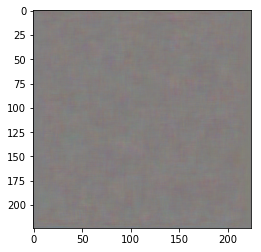

In [40]:
plt.imshow(inverse_normalization(generator_model.predict(sample_noise(0.5,1,(100,))))[0])

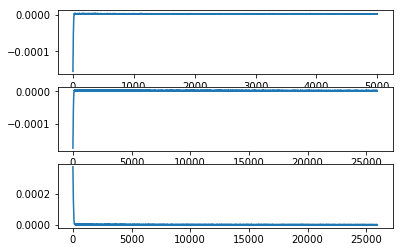

In [43]:
plt.subplot(311)
plt.plot(big_list_gen_loss_stl10)
plt.subplot(312)
plt.plot(big_list_disc_loss_real_stl10)
plt.subplot(313)
plt.plot(big_list_disc_loss_gen_stl10)

## repurpose the discriminator for our classification task

In [44]:
bc_normalized_train_path = f'{path}trn_resized_{new_s}_normalized_train_r.bc'
bc_normalized_test_path = f'{path}trn_resized_{new_s}_normalized_test_r.bc'

In [ ]:
normalized_train_arr = bcolz.carray(np.empty((0, 224, 224, 3),
                                       'float32'), chunklen=16, mode='w', rootdir=bc_normalized_train_path)
normalized_test_arr = bcolz.carray(np.empty((0, 224, 224, 3),
                                       'float32'), chunklen=16, mode='w', rootdir=bc_normalized_test_path)

In [41]:
def parrelel_normalize_train_images(step, n, images, arr):
    for i in tqdm(range(0, n, step)):
        with ThreadPoolExecutor(max_workers=8) as execr:
            res = execr.map(lambda x: normalization(x , 'tf') , images[i:min(i+step, n)])
            for r in res: 
                tl.place[:] = r
                arr.append(r)
        arr.flush()
parrelel_normalize_train_images(1000,len(train_imgs), train_imgs, normalized_train_arr)

100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


In [42]:
parrelel_normalize_train_images(1000,len(train_imgs), val_imgs, normalized_test_arr)

100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


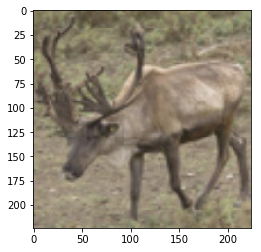

In [34]:
# take a look at a random example and make sure the image data and labels are sound
normalized_train_arr = bcolz.open(bc_normalized_train_path)
normalized_test_arr = bcolz.open(bc_normalized_test_path)
plt.imshow(inverse_normalization(normalized_train_arr[0]).astype('uint8'))
print(train_labels[0])

In [35]:
batches = get_batches(normalized_train_arr, train_labels, batch_size=16)
val_batches = get_batches(normalized_test_arr, val_labels, batch_size=16)

In [36]:
discriminator_model_stl10 = discriminator((224,224,3), 2)

In [49]:
discriminator_model_stl10.load_weights('/home/derek/jupyter/nbs/data/stl10/discriminator_epoch5.h5')

In [38]:
def repurpose_model(model):
    x = model.layers[-3].output
    # change it to num_class
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='softmax')(x)
    return Model(input=model.get_input_at(0), output=x)
discriminator_model_stl10 = repurpose_model(discriminator_model_stl10)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
discriminator_model_stl10.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_crossentropy', 'accuracy'])

In [51]:
visualize_model(discriminator_model_stl10)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
discriminator_input (InputLayer) (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
disc_conv2d_1 (Convolution2D)    (None, 112, 112, 64)  1728        discriminator_input[0][0]        
____________________________________________________________________________________________________
batchnormalization_11 (BatchNorm (None, 112, 112, 64)  256         disc_conv2d_1[0][0]              
____________________________________________________________________________________________________
leakyrelu_6 (LeakyReLU)          (None, 112, 112, 64)  0           batchnormalization_11[0][0]      
___________________________________________________________________________________________

In [52]:
# fit the model with pre-loaded weights from the unsuperwised training earlier 
discriminator_model_stl10.fit_generator(batches, 4000, nb_epoch=1,
            validation_data=val_batches, nb_val_samples=1000)

Epoch 1/1
4000/4000 [==============================] - 53s - loss: 2.3058 - categorical_crossentropy: 2.3058 - acc: 0.0963 - val_loss: 2.3063 - val_categorical_crossentropy: 2.3063 - val_acc: 0.1010


In [39]:
# fit the data with randomised weights
discriminator_model_stl10 = discriminator((224,224,3), 2)
discriminator_model_stl10 = repurpose_model(discriminator_model_stl10)
discriminator_model_stl10.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_crossentropy', 'accuracy'])
discriminator_model_stl10.fit_generator(batches, 4000, nb_epoch=1,
            validation_data=val_batches, nb_val_samples=1000)

Epoch 1/1
4000/4000 [==============================] - 53s - loss: 14.2613 - categorical_crossentropy: 14.2613 - acc: 0.0995 - val_loss: 14.6836 - val_categorical_crossentropy: 14.6836 - val_acc: 0.0890


Having a rough look at the metrics from above supervised and unsupervised runs, together with the image result produced by the generator model after earlier training, the unsupervised learning doesn't seem to be very helpful in producing a better set of starting weights for our discriminator training even though I've experienced better results previously when I tested the approach with mnist and celebA. A few ideas for further exploration are,
1. The STL10 dataset is huge and I've only been able to run up to 35 epochs of 400 batches with the limited power of my GTX970 GPU, which might be too small for WGAN training on the dataset to produce meaningful results. I'd try training more epochs and see if it makes any difference at all.
2. Both mnist and celebA have unique features in its data which represent very specific underlying distributions(e.g. hand-written digits, faces); however, stl10 data contains a wider range of categories and features and constitutes a more complex or random distribution which are harder to capture with our approach. I'd try to seperate the training of individual fold/category of stl10 data and see if the performance gets better under the same number of batches of training. 